# Installing packages and modules
As a part of this assignment, some external packages and modules are required. Namely:


*   Tesseract and PyTesseract
*   Swig 3.0
*   NLTK corpora and tokenizers
*   JamSpell and its English language model



In [ ]:
!apt install tesseract-ocr swig3.0
!pip install pytesseract jamspell
!python3 -m nltk.downloader all
!wget https://github.com/bakwc/JamSpell-models/raw/master/en.tar.gz
!tar -xvzf en.tar.gz

# Importing modules
This notebook assumes that the following Python modules are already installed and configured:


*   OpenCV
*   Python Imaging Library (PIL)
*   NumPy
*   Natural Language Toolkit (NLTK)
*   Imutils






In [ ]:
import cv2
from PIL import Image, ImageSequence
import numpy as np
import pytesseract
import imutils
import nltk
import re
import jamspell

In [99]:
FILE_PATH = '/content/Assignment_1.tiff'
ROTATE = True

# Pre-processing the image
The image has been pre-processed using OpenCV for the OCR task. 
1. First the image is converted from RGB to grayscale
2. Then the text orientation of the image is identified, and the image is rotated accordingly to ensure the text is in the portrait orientation.
3. A Gaussian blur is applied to the image
4. The image is binarized using Otsu's binarization which computes the local threshold automatically

In [61]:
def preprocessImage(path: str, rotate=True):
  # img from RGB to gray
  image = cv2.imread(path)
  image= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

  if rotate:
    # identify text orientation
    rot_data = pytesseract.image_to_osd(image)
    rot = re.search('(?<=Rotate: )\d+', rot_data).group(0)

    # rotate image to bring it to portrait
    image = imutils.rotate_bound(image, float(rot))

  # apply Gaussian blur
  blur = cv2.GaussianBlur(image, (3,3), 0)

  # binarize the image using Otsu's binarization
  _, image = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  return image

# Extracting text using OCR
Tesseract OCR extracts the textual data from the image, and provides a set of bounding box coordinates where the text was detected (text localization).

A threshold confidence level of 60% has been set so that malformed or wrongly identified text is excluded from the predictions.

Moreover, spaces, punctuation, special characters, contractions and ordinals have been substituted suitably

In [95]:
def extractText(image):
  # extract text from image
  data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
  output = []
  for i in range(len(data["text"])):
    # get the confidence and bounding boxes of the text localization
    x = data["left"][i]
    y = data["top"][i]
    w = data["width"][i]
    h = data["height"][i]
    text = data["text"][i]
    confidence = int(data["conf"][i])
    # confidence threshold
    if confidence>= 60:
      # substitution map
      subMap = { '\n': ' ', '\\': ' ', '\"': '"', '-': ' ', '"': ' " ', 
          '"': ' " ', '"': ' " ', ',':' , ', '.':' . ', '!':' ! ', 
          '?':' ? ', "n't": " not" , "'ll": " will", '*':' * ', 
          '(': ' ( ', ')': ' ) ', "s'": "s '", "1st": "first",
          "2nd": "second", "3rd": "third", "_": ' _ ', "[":" [ ", "]": " ] "}
      subMap = dict((re.escape(k), v) for k, v in subMap.items()) 
      pattern = re.compile("|".join(subMap.keys()))
      text = pattern.sub(lambda m: subMap[re.escape(m.group(0))], text.strip())

      if(text):
        output.append({'text': text, 'x': x, 'y': y, 'w': w, 'h': h})
  return output

# Named Entity Recognition (NER)
To avoid proper nouns such as names of people, places or institutions from being passed through the spell checker and potentially being wrongly corrected, these named entities are first identified and put into a list.

This is done by first tokenizing the sentences, and then for each sentence, tokenizing at the word level. If the word is identified to be a named entity, it is inserted into a list.

In [63]:
def namedEntityRecognition(data: dict) -> set:
  personslist = []
  text = " ".join(word['text'] for word in data)

  # tokenize each sentence
  for sent in nltk.sent_tokenize(text):
    # tokenize each word
      for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
        # check for named entities
          if isinstance(chunk, nltk.tree.Tree) and chunk.label() in ['PERSON', 'GPE', 'ORGANIZATION']:
            # insert into list
              personslist.insert(0, (chunk.leaves()[0][0]))

  # convert to set to remove duplication
  personslist = list(set(personslist))
  # add special characters and punctuation to avoid passing them into the spell checker
  return set(personslist + ["!", ",", ".", "\"", "?", '(', ')', '*', '"', "[", "]", "{", "}", "_"])

# Spell checker
Every word in the text is split, and if any of the parts of the word intersect with the ignored words set as described above, they are excluded from the spell checking process.

The other words are passed into the spell checker. If the word is incorrect, it is replaced by its closest correct value. If the corrected word is different from the original word (i.e. a spelling error was detected) it is recorded with its bounding box and corrected spelling.

In [64]:
def spellChecker(data: dict, ignorewords: set) -> list:
  text = [word['text'] for word in data]
  corrections = []

  for i, word in enumerate(text):
    # check if the word intersects with the ignored words set
    if not (set(word.split()) & ignorewords):
      # put the word through the spell checker
      corrected = corrector.FixFragment(word)
      text[i] = corrected
      # if the word was incorrect
      if (corrected != word):
        # record the correction along with its bounding box
        corrections.append(data[i])
        corrections[-1]['text'] = corrected

  return corrections

# Annotating the image with corrections
The image is first converted back from grayscale to RGB so that annotations of a different colour may be drawn.

Then for each correction that was recorded, draw a rectangle with the coordinates of the bounding box, and write the corrected word above the box.

In [65]:
def annotateImage(image, corrections: dict):
  backtorgb = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

  for word in corrections:
    x, y, w, h, text = word['x'], word['y'],word['w'], word['h'], word['text']
    image = cv2.rectangle(backtorgb, (x, y), (x + w, y + h), (255, 0, 0), 1)
    cv2.putText(image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

  return image

# Driver code

In [ ]:
IMAGE_PATH = []
# Splitting multi-image TIFF files into individual images
if (FILE_PATH.endswith('.tiff')):
  im = Image.open(FILE_PATH)
  for i, page in enumerate(ImageSequence.Iterator(im)):
    path = FILE_PATH.replace('.tiff', '')
    filepath = f'{path}_{i}.png'
    IMAGE_PATH.append(filepath)
    page.save(filepath)
else:
  IMAGE_PATH.append(FILE_PATH)

for path in IMAGE_PATH:
  print(path)
  image = preprocessImage(path, ROTATE)
  data = extractText(image)
  ignorewords = namedEntityRecognition(data)
  corrections = spellChecker(data, ignorewords)
  annotated = annotateImage(image, corrections)
  cv2.imwrite(path.split('.')[0] + "_corrected.png", annotated)

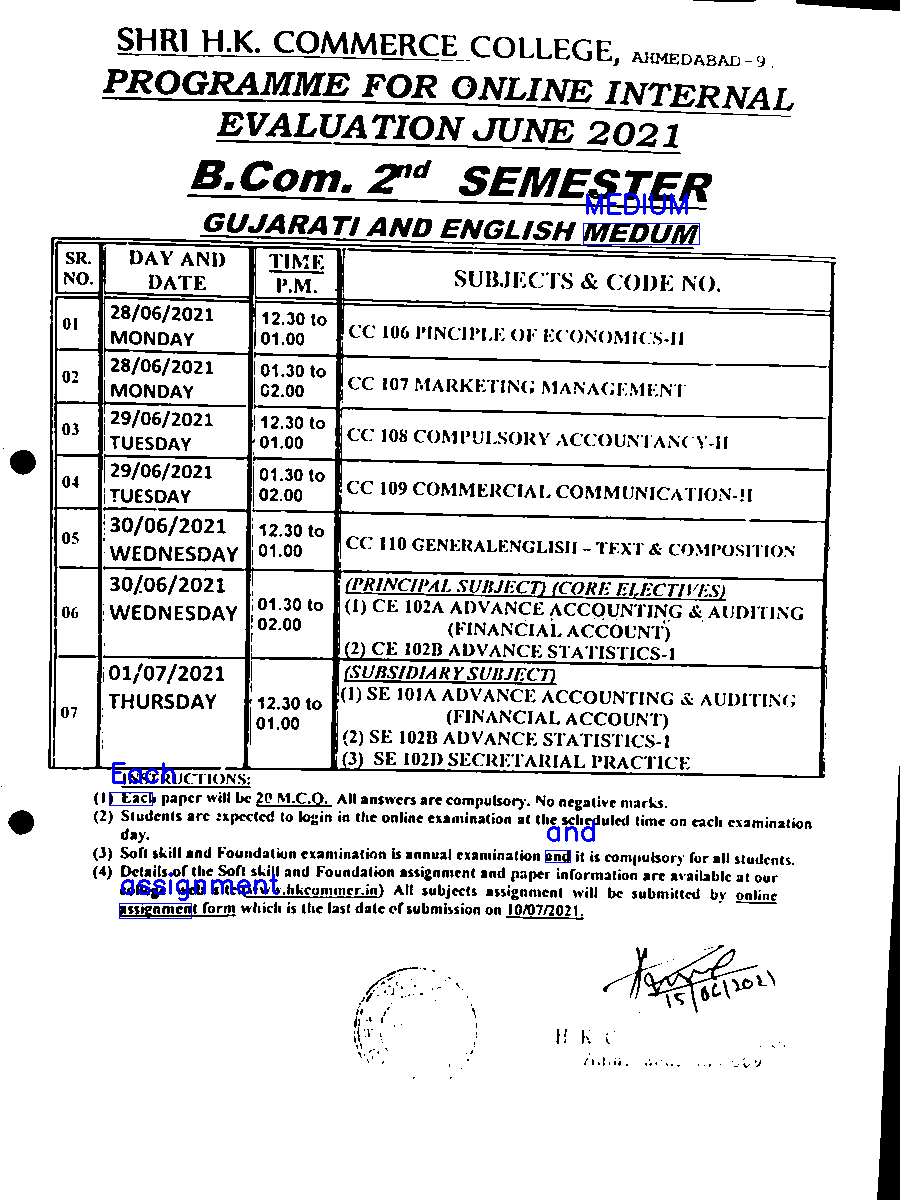

In [103]:
Image.open('/content/Assignment_1_2_corrected.png')